# **Named Entity Recognition on a collection of Wikipedia texts**

Alex Costa, Alessia Antognini, Tommaso Biganzoli, Giovanni Caminiti | Università Cattolica del Sacro Cuore | Text Mining

In [ ]:
#!pip install --upgrade pyLDAvis keras_utils
#!python -m spacy download en_core_web_lg

In [ ]:
# Standard imports
import pandas as pd
import numpy as np
import csv
import os

# Plots
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import pyLDAvis
import pyLDAvis.lda_model

# Machine Learning / NLP
import spacy
import nltk
from nltk.corpus import stopwords
from gensim.corpora import Dictionary
from gensim.models import LdaModel
import pyLDAvis.gensim_models as gensimvis
from collections import defaultdict
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Embedding, TimeDistributed, Dense, InputLayer, Dropout, LSTM, Bidirectional, BatchNormalization
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# Transformers
from transformers import Trainer, TrainingArguments, AutoTokenizer
from transformers import BertForTokenClassification, BertTokenizerFast
from transformers import get_linear_schedule_with_warmup, Adafactor

# Utilities
from google.colab import drive
import string
import warnings
from pprint import pprint
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler, Dataset
from torch.optim import AdamW
import random
import pickle
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
import ipywidgets as widgets
from IPython.display import display

# 1. Introduction and Data Preprocessing

The dataset contains a collection of texts from different Wikipedia articles, that have already been splitted in tokens and each token was assigned an IOB tag. IOB, which stands for Inside-Outside-Beginning, is a common tagging format used in computational linguistics for tasks like **Named Entity Recognition (NER)**, which is the task of this project. In this case five tags were used:

1.   I-PER: person
2.   I-LOC: location
3.   I-ORG: organization
4.   I-MISC: miscellaneous, i.e. named entities that don't belong to the previous categories
5.   O: outside, i.e. not a named entity

In [ ]:
drive.mount('/content/drive')
os.chdir("/content/drive/MyDrive/Università/Text Mining")
file_path = "https://raw.githubusercontent.com/nluninja/text-mining-dataviz-project-2024/refs/heads/main/Text%20Me%20Maybe/data/file1.ann"

Mounted at /content/drive


In [ ]:
data = pd.read_csv(file_path, sep=' ', header=None, names=['Token', 'Tag'], quoting=csv.QUOTE_NONE, skip_blank_lines=True)
data

,Token,Tag
0,010,I-MISC
1,is,O
2,the,O
3,tenth,O
4,album,O
...,...,...
39147,a,O
39148,Russian,I-MISC
39149,singer,O
39150,.,O


After loading the dataset, we check for the presence of **missing values** and **empty strings**, which could cause problems in the models training and mess up token-tag alignment.

In [ ]:
# Check for NaNs
print("NaN values per column:")
print(data.isna().sum())

NaN values per column:
Token    0
Tag      0
dtype: int64


In [ ]:
# Check for empty strings
print("\nEmpty strings per column:")
print((data == '').sum())


Empty strings per column:
Token    0
Tag      0
dtype: int64


There are neither NA nor empty strings in the dataset, hence it is already complete. However, at the end of every document we have the token "-DOCSTART-", which has to be removed. First we aggregate tokens in **sentences** using "-DOCSTART-" and punctuation as delimeters, and then we remove them. The models that we will use need sentence-level input without punctuation.

In [ ]:
# Aggregate tokens into sentences
SENTENCE_ENDINGS = {'.', '!', '?'}

def split_into_sentences(data):
    sentences = []
    current_sentence = []

    for token, tag in zip(data['Token'], data['Tag']):
        if token == "-DOCSTART-" or token == "DOCSTART":
            if current_sentence:
                sentences.append(current_sentence)
                current_sentence = []
            continue

        current_sentence.append((token, tag))

        if token in SENTENCE_ENDINGS:
            sentences.append(current_sentence)
            current_sentence = []

    if current_sentence:
        sentences.append(current_sentence)

    return sentences

In [ ]:
def clean_sentences(sentences):
    cleaned = []
    for sentence in sentences:
        cleaned_sentence = [
            (token, tag) for token, tag in sentence
            if token != "-DOCSTART-" and token != "DOCSTART" and token not in string.punctuation
        ]
        if cleaned_sentence:
            cleaned.append(cleaned_sentence)
    return cleaned

In [ ]:
sentences_raw = split_into_sentences(data)
sentences = clean_sentences(sentences_raw)
full_text = ' '.join(char for sentence in sentences for (char, *_) in sentence)

In [ ]:
sentences[0]

[('010', 'I-MISC'),
 ('is', 'O'),
 ('the', 'O'),
 ('tenth', 'O'),
 ('album', 'O'),
 ('from', 'O'),
 ('Japanese', 'I-MISC'),
 ('Punk', 'O'),
 ('Techno', 'O'),
 ('band', 'O'),
 ('The', 'I-ORG'),
 ('Mad', 'I-ORG'),
 ('Capsule', 'I-ORG'),
 ('Markets', 'I-ORG')]

In [ ]:
# Recreate cleaned dataframe
flat_data = [pair for sentence in sentences for pair in sentence]
data_clean = pd.DataFrame(flat_data, columns=["Token", "Tag"])
data_clean

,Token,Tag
0,010,I-MISC
1,is,O
2,the,O
3,tenth,O
4,album,O
...,...,...
33963,Gazmanov,I-PER
33964,is,O
33965,a,O
33966,Russian,I-MISC


In [ ]:
# Flatten tokens and tags
all_tokens = [token for sent in sentences for token, _ in sent]
all_tags = [tag for sent in sentences for _, tag in sent]

The dataset is now properly cleaned and structured, making it ready for the upcoming tasks.

# 2. Exploratory Data Analysis

<ipython-input-16-417aeebcd5c7>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data_clean, x="Tag", order=data_clean["Tag"].value_counts().index, palette ='rainbow')


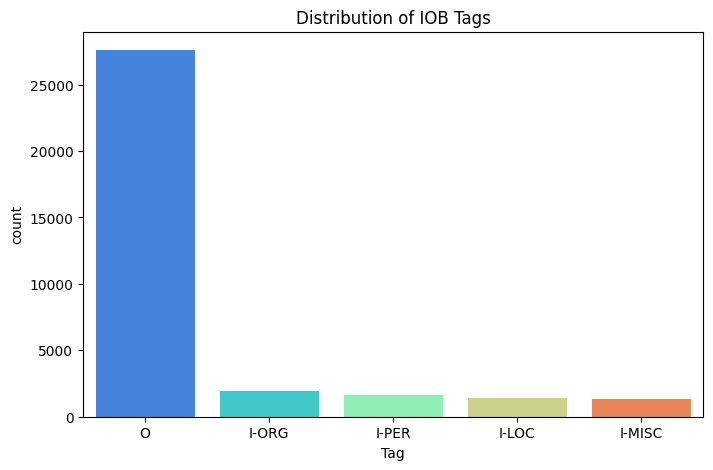

In [ ]:
# Tag distribution
plt.figure(figsize=(8,5))
sns.countplot(data=data_clean, x="Tag", order=data_clean["Tag"].value_counts().index, palette ='rainbow')
plt.title("Distribution of IOB Tags")
plt.show()

The 'O' tag (Outside) dominates the dataset, meaning most tokens are not part of named entities. Named entities (I-PER, I-LOC, I-ORG, I-MISC) are relatively balanced, though I-ORG appears slightly more frequent than others.

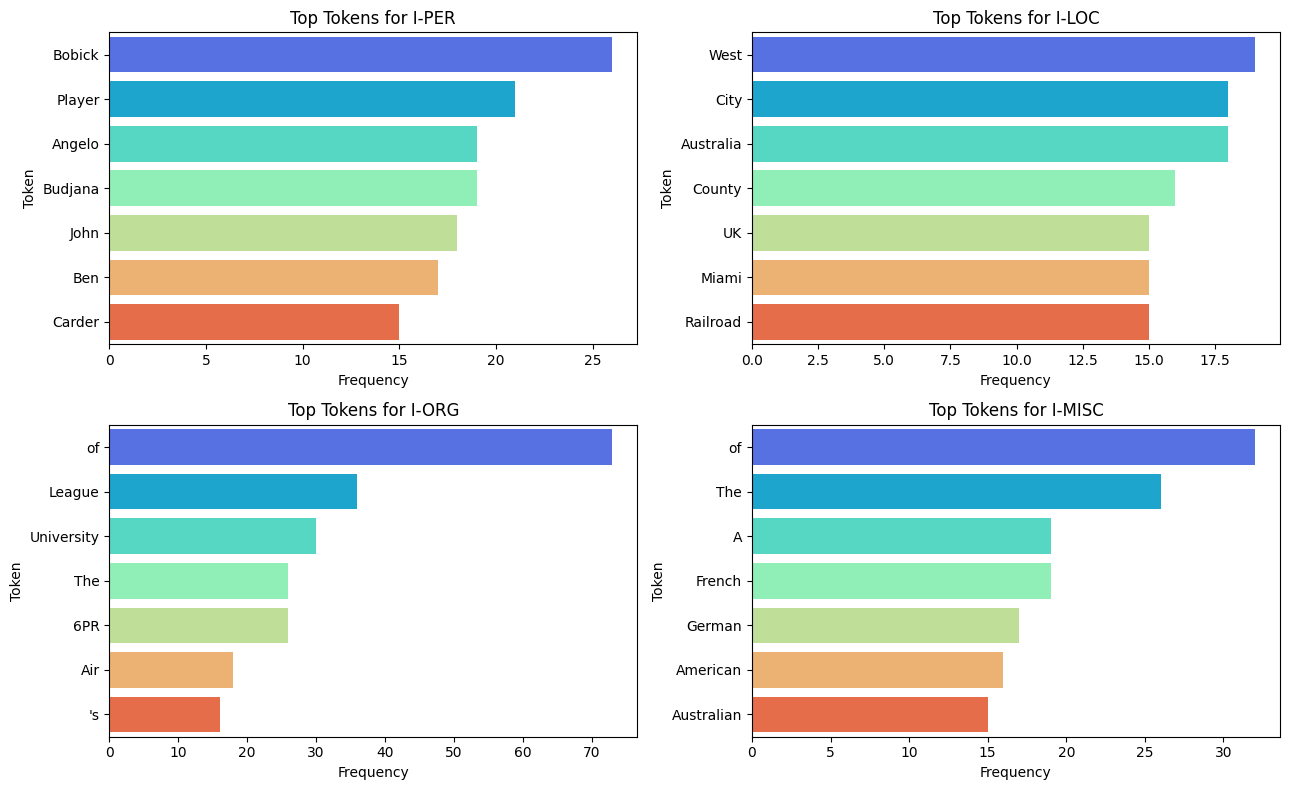

In [ ]:
# Most Frequent Tokens per Entity
entity_tags = ['I-PER', 'I-LOC', 'I-ORG', 'I-MISC']
fig, axes = plt.subplots(2, 2, figsize=(13, 8))
axes = axes.flatten()

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    for i, tag in enumerate(entity_tags):
      top_tokens = (
          data_clean[data_clean['Tag'] == tag]['Token']
          .value_counts()
          .head(7)
      )

      sns.barplot(x=top_tokens.values, y=top_tokens.index, ax=axes[i], palette="rainbow")
      axes[i].set_title(f"Top Tokens for {tag}")
      axes[i].set_xlabel("Frequency")
      axes[i].set_ylabel("Token")

plt.tight_layout()
plt.show()


Each subplot above shows the top 7 most frequent tokens labeled as Person, Location, Organization and Miscellaneous.

<ipython-input-18-9f0f47a06dc6>:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(sentence_lengths, bins=30, palette ='rainbow')


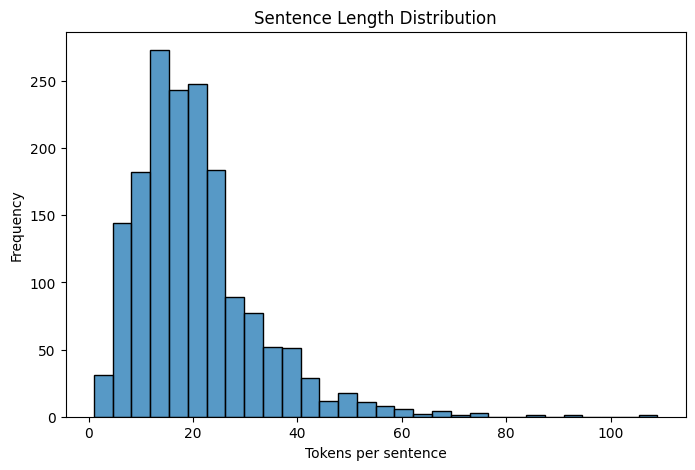

In [ ]:
# Sentence length distribution
sentence_lengths = [len(s) for s in sentences]

plt.figure(figsize=(8,5))
sns.histplot(sentence_lengths, bins=30, palette ='rainbow')
plt.title("Sentence Length Distribution")
plt.xlabel("Tokens per sentence")
plt.ylabel("Frequency")
plt.show()

Most sentences contain 10–30 tokens, with a long tail with some sentences going over 80–100 tokens.

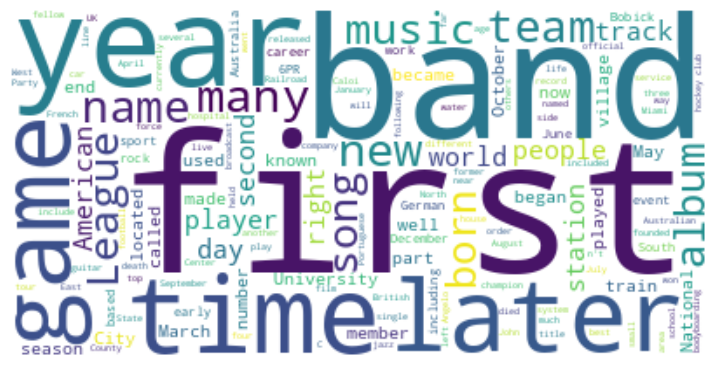

In [ ]:
# Wordcloud
stopw = set(STOPWORDS) # stopwords in the wordcloud package
stopw.add("S")
stopw.add("one")
stopw.add("two")

data_wc = WordCloud(background_color='white', stopwords=stopw)
data_wc.generate(full_text)

fig = plt.figure(figsize=(9, 12))
plt.imshow(data_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

The word cloud highlights common tokens found in the corpus, with 'first', 'band', 'year'and 'time' being among the most prominent. These terms reflect the dataset's focus on Wikipedia content.

To further explore the semantic structure of the corpus, we apply **Latent Dirichlet Allocation (LDA)**, a generative probabilistic model widely used for topic modelling. LDA assumes that documents are mixtures of topics, and each topic is characterized by a distribution over words. This technique allows us to uncover latent themes that may not be apparent through simple frequency-based methods.

In [ ]:
# Define stopwords and add custom words
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))
custom_stopwords = {'one', 'two', 'three','1','2','3'}
stop_words = stop_words.union(custom_stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# Function to clean and preprocess a sentence
def preprocess_sentence(sentence):
    cleaned = []
    for token, tag in sentence:
        token = token.lower().strip(string.punctuation)
        if token and token not in stop_words and token not in string.punctuation:
            cleaned.append(token)
    return cleaned

In [ ]:
cleaned_sentences = [preprocess_sentence(sent) for sent in sentences if len(sent) > 2]

In [ ]:
# Create dictionary and corpus for LDA
dictionary = Dictionary(cleaned_sentences)
corpus = [dictionary.doc2bow(sent) for sent in cleaned_sentences]

# Build LDA model
lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=5,
    random_state=42,
    update_every=1,
    chunksize=100,
    passes=10,
    alpha='auto',
    per_word_topics=True
)

# Show topics
pprint(lda_model.print_topics())

[(0,
  '0.009*"later" + 0.008*"became" + 0.007*"first" + 0.006*"well" + '
  '0.005*"express" + 0.005*"people" + 0.005*"however" + 0.005*"train" + '
  '0.005*"games" + 0.005*"played"'),
 (1,
  '0.007*"change" + 0.007*"fares" + 0.007*"born" + 0.006*"dutch" + 0.006*"use" '
  '+ 0.005*"another" + 0.004*"ii" + 0.004*"schlegel" + 0.004*"original" + '
  '0.004*"old"'),
 (2,
  '0.009*"name" + 0.008*"music" + 0.007*"used" + 0.007*"system" + '
  '0.007*"since" + 0.006*"budjana" + 0.006*"area" + 0.005*"including" + '
  '0.005*"mix" + 0.005*"world"'),
 (3,
  '0.009*"trax" + 0.009*"ez2dj" + 0.007*"washington" + 0.007*"german" + '
  '0.006*"album" + 0.006*"1st" + 0.006*"made" + 0.005*"community" + '
  '0.005*"service" + 0.005*"also"'),
 (4,
  '0.013*"state" + 0.011*"fairmont" + 0.011*"university" + 0.009*"bobick" + '
  '0.009*"located" + 0.007*"college" + 0.006*"2007" + 0.006*"may" + '
  '0.006*"fairfax" + 0.006*"west"')]


We have decided to search for 5 topics. Each tuple from the output above represents a topic, showing the most relevant words (by probability) that characterize that topic:

-   **Topic 1**: this topic seems to reflect narratives or chronological descriptions, particularly involving changes or achievements over time. Keywords like "later," "became," "first," "played," and "train" suggest the progression of events, possibly within biographical or historical entries.

-   **Topic 2**: this topic captures themes related to personal origin ("born," "dutch," "schlegel") and perhaps transportation or pricing ("fares," "change").

-   **Topic 3**: focuses on digital or media-related subjects, possibly musical systems, names of artists, or technologies ("music," "system," "used," "mix"). The presence of "Budjana" (likely Dewa Budjana, an Indonesian musician) supports this.

-   **Topic 4**: this topic leans toward musical or gaming culture ("trax," "ez2dj," "album," "1st"), and possibly ties into community services or locations ("washington," "german," "community").

-   **Topic 5**: strongly educational or institutional, with names of universities ("fairmont," "college," "state") and locations ("west," "fairfax"). The keyword "Bobick" might refer to an academic or notable person.

We generate an **interactive bubble plot** providing a clear and intuitive way to explore the main topics extracted from the dataset through LDA. In this visualization, each bubble represents a distinct topic and the size of the bubble reflects the prevalence of that topic across the corpus. Meanwhile, the position of each bubble on the two-dimensional plane is determined by the topic's similarity to others: closely positioned bubbles suggest related topics, while distant ones indicate more distinct themes.

In [ ]:
# Bubble plot LDA
pyLDAvis.enable_notebook()

# Prepare the visualization
lda_vis = gensimvis.prepare(lda_model, corpus, dictionary)

# Display the visualization (inside a Jupyter notebook)
pyLDAvis.display(lda_vis)

We can see from the plot that topics 2, 3 and 5 are closely related, while topics 1 and 4 are distanct from all the others.

# 3 Data Processing for Neural Networks

We need to do some additional operations before training our models. First, we build the **vocabulary** mappings needed for transforming text tokens and NER tags into numerical values, which neural networks require as input.

In [ ]:
# Create vocabulary
word_set = sorted(set(all_tokens)) # Remove duplicates
word2idx = defaultdict(lambda: word2idx["<UNK>"]) # if you try to get a word that doesn't exist in the dictionary, it returns <UNK> instead of an error
word2idx = {word: idx + 2 for idx, word in enumerate(word_set)} # dictionary mapping each word to a unique number
word2idx["<PAD>"] = 0
word2idx["<UNK>"] = 1

tag_set = sorted(set(all_tags))
tag2idx = {tag: idx  for idx, tag in enumerate(tag_set)}
tag2idx['PAD'] = len(tag2idx)
idx2tag = {idx: tag for tag, idx in tag2idx.items()} # inverse tag dictionary

Then we convert tokens and tags to indices and we pad the sequences. **Padding** is a technique used for achieving sequences of same length, which is essential to allow the neural networks to process the inputs consistently and efficiently.

In [ ]:
print(f'Number of sentences: {len(sentence_lengths)}')
print(f'Maximum length: {max(sentence_lengths)}')
print(f'Sentences longer than 70: {len([s for s in sentence_lengths if s > 70])}')

Number of sentences: 1671
Maximum length: 109
Sentences longer than 70: 6


The maximum length of our sequences is 109, but only 6 of the 1671 sentences have more than 70 tokens, so we choose the maximum length of the sentences after padding to be **70**. Hence, for sentences shorter than 70 we add as many zeros at the end as needed to reach that length, while for longer sentences we remove all the tokens after the first 70.

In [ ]:
# Convert tokens and tags to indices
X = [[word2idx.get(token, word2idx["<UNK>"]) for token, _ in s] for s in sentences]
y = [[tag2idx[tag] for _, tag in s] for s in sentences]

# Padding
MAX_LEN = 70
X = pad_sequences(X, maxlen=MAX_LEN, padding="post", value=word2idx["<PAD>"])
y = pad_sequences(y, maxlen=MAX_LEN, padding="post", value=tag2idx["PAD"])

Then we apply **one-hot encoding** to the labels.

In [ ]:
y = [to_categorical(i, num_classes=len(tag2idx)) for i in y]

Finally, we divide the dataset into a **training set** (80%), a **validation set** (10%) and a **test set** (10%). We will use the train set to train our models, the validation set to monitor the model's performance during training, preventing overfitting or underfitting, and the test set to evaluate the models' final performance on unseen data.

In [ ]:
# First split: Train (80%) and Temp (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Second split: Validation (10%) and Test (10%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Check sizes
print(f"Train size: {len(X_train)}")
print(f"Validation size: {len(X_val)}")
print(f"Test size: {len(X_test)}")

Train size: 1336
Validation size: 167
Test size: 168


In [ ]:
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

Then, we apply tokenization with Keras' Tokenizer to create a vocabulary that assigns an integer ID to each unique word in the training, validation, and test sets. This converts the text data into a numerical format suitable for the models.

We now use the word2idx and tag2idx dictionaries we built to convert each sentence and corresponding tag sequence into a list of integers.

# 4. Word Embedding

A **word embedding** is a representation of words as a real-valued vectors that encodes the meaning of the words in such a way that the words that are closer in the vector space are expected to be similar in meaning. We use a pretrained emebdding called **GloVe** (Global Vectors for Word Representation), which builds word embeddings based on global co-occurrence in the corpus. We use a pretrained embedding instead of an embedding layer, which learns during training, because the dataset is not large enough to confidently learn rich embeddings from scratch.

In [ ]:
#!wget http://nlp.stanford.edu/data/glove.6B.zip
#!unzip "glove.6B.zip"

Specifically, we load the GloVE 6B 100d, which has vector representations of dimension 100 for 6 billion words and characters.

In [ ]:
# Load the GloVe embeddings into a dictionary
embeddings_index = {}
with open('glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.strip().split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = vector

print(f"Loaded {len(embeddings_index):,} word vectors from GloVe.")

Loaded 400,000 word vectors from GloVe.


In [ ]:
# Vocabulary size
vocab_size = len(word2idx)
embedding_dim = 100

# Create embedding matrix: initialize with zeros
embedding_matrix = np.zeros((vocab_size, embedding_dim))

# Fill matrix with GloVe vectors where available
for word, idx in word2idx.items():
    if word in embeddings_index:
        embedding_matrix[idx] = embeddings_index[word]
    else:
        # Random small values for OOV words (optional)
        embedding_matrix[idx] = np.random.normal(scale=0.6, size=(embedding_dim,))

print("Embedding matrix shape:", embedding_matrix.shape)  # Should be (vocab_size, embedding_dim)

Embedding matrix shape: (8486, 100)


We now run a **PCA** on the words of the first six sentences and we plot them using the first two principal components as coordinates, so that we can verify that semantically similar words are close in space in their GloVe vector representations.

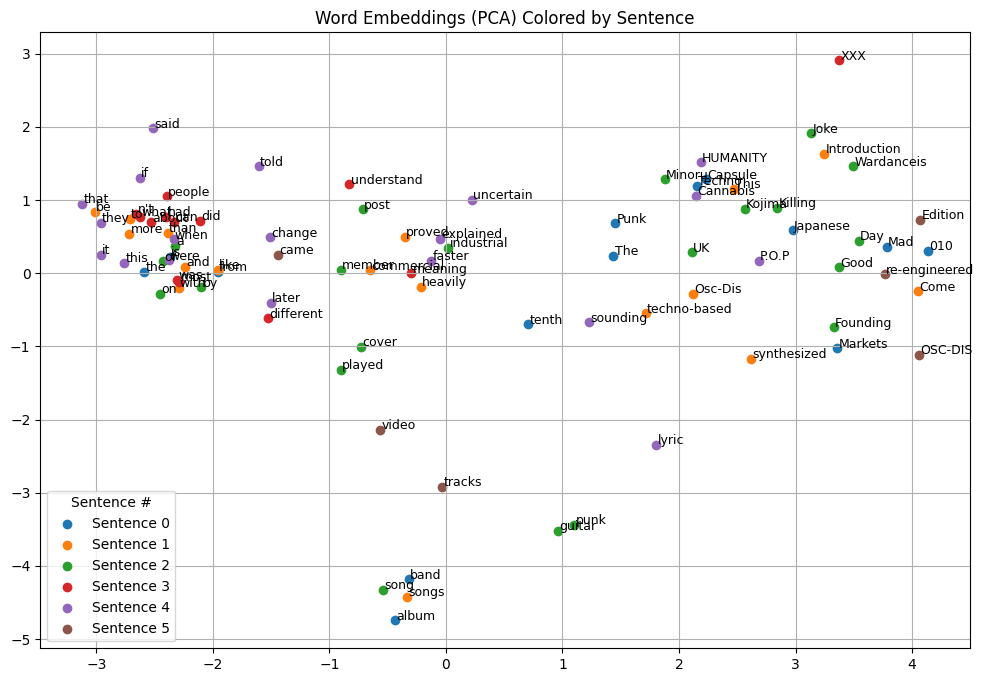

In [ ]:
# Get tokens from first 6 sentences with sentence index
first_6_sentences = sentences[:6]
word_sentence_pairs = []
for i, sentence in enumerate(first_6_sentences):
    for token, _ in sentence:
        word_sentence_pairs.append((token, i))

# Get unique words and their sentence number (first occurrence)
seen = {}
for word, sent_idx in word_sentence_pairs:
    if word not in seen and word in word2idx:
        seen[word] = sent_idx

words = list(seen.keys())
sentence_indices = list(seen.values())

# Get embeddings
vectors = np.array([embedding_matrix[word2idx[word]] for word in words])

# Reduce with PCA
pca = PCA(n_components=2)
reduced = pca.fit_transform(vectors)

# Plot
plt.figure(figsize=(12, 8))
colors = cm.tab10(sentence_indices)  # 6 unique colors for 6 sentences

for i, word in enumerate(words):
    plt.scatter(reduced[i, 0], reduced[i, 1], color=colors[i], label=f"Sentence {sentence_indices[i]}")
    plt.text(reduced[i, 0] + 0.01, reduced[i, 1] + 0.01, word, fontsize=9)

# Remove duplicate labels in the legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), title="Sentence #")

plt.title("Word Embeddings (PCA) Colored by Sentence")
plt.grid(True)
plt.show()

We can identify some clusters of seamntically similar words that are indeed close in space, for example:
- song, songs, album, guitar, punk, tracks, lyric
- this, that, with, where, on, to, like


# 5. Feed Forward NN

In this section we introduce a baseline neural network architecture for the Named Entity Recognition task: the **Feed Forward Neural Network** (FFNN). Although FFNNs are not inherently designed to handle sequential data like texts, they can still be applied by treating each token independently. This allows us to establish a simple yet informative benchmark before moving to more advanced models such as LSTM and BERT.

We use a token-level FFNN where each word is first mapped to a dense vector through the GloVe embedding, and then passed through **two fully connected layers**, the first with ReLu and the second with SoftMax activation functions. The model is trained using categorical cross-entropy loss and Adam optimizer for a maximum of 30 epochs with an early stopping on validation loss to prevent overfitting. We also apply **class weights** during training to give more weight to the minority classes.



In [ ]:
# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(np.argmax(y_train, axis=-1).ravel()),
                                     y=np.argmax(y_train, axis=-1).ravel())


# Convert one-hot to class indices
y_indices = np.argmax(y_train, axis=-1)

# Initialize sample weights with same shape
sample_weights = np.take(class_weights, y_indices)

In [ ]:
def masked_accuracy(y_true, y_pred):
    # Convert one-hot to integer labels
    y_true_labels = tf.argmax(y_true, axis=-1)
    y_pred_labels = tf.argmax(y_pred, axis=-1)

    # Create mask to ignore PAD tokens
    mask = tf.math.not_equal(y_true_labels, tag2idx['PAD'])
    mask = tf.cast(mask, tf.float32)

    # Compare predictions and true labels
    matches = tf.cast(tf.equal(y_true_labels, y_pred_labels), tf.float32)

    # Apply mask and compute accuracy
    return tf.reduce_sum(matches * mask) / tf.reduce_sum(mask)

In [ ]:
# Set the seed
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [ ]:
# Define the model
ff_model = Sequential([
    InputLayer(shape=(MAX_LEN,)),
    Embedding(input_dim=len(word2idx), output_dim=embedding_dim, weights=[embedding_matrix], trainable=False),
    TimeDistributed(Dense(128, activation='relu')),
    TimeDistributed(Dropout(0.4)),
    TimeDistributed(Dense(len(tag2idx), activation='softmax'))
])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Compile the model
ff_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[masked_accuracy])

In [ ]:
# Train the model
history_ff = ff_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    sample_weight=sample_weights,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 18s 74ms/step - loss: 1.5673 - masked_accuracy: 0.4924 - val_loss: 0.2662 - val_masked_accuracy: 0.7454
Epoch 2/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 1.2083 - masked_accuracy: 0.7004 - val_loss: 0.2442 - val_masked_accuracy: 0.7557
Epoch 3/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 1.1055 - masked_accuracy: 0.7251 - val_loss: 0.2302 - val_masked_accuracy: 0.7776
Epoch 4/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 1.0553 - masked_accuracy: 0.7361 - val_loss: 0.2216 - val_masked_accuracy: 0.7587
Epoch 5/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 1.0165 - masked_accuracy: 0.7428 - val_loss: 0.2156 - val_masked_accuracy: 0.7677
Epoch 6/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 1.0011 - masked_accuracy: 0.7483 - val_loss: 0.2116 - val_masked_accuracy: 0.7736
Epoch 7/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.9723 - masked_accuracy: 0.7554 - val_loss: 0.2087 - val_masked_accuracy: 0.7783
Epoch 8/30
4

In [ ]:
def plot_history(history, model_name="Model"):
    """Plots training and validation accuracy and loss."""
    history_dict = history.history

    # Adjusted to match custom metric name
    acc = history_dict.get('masked_accuracy')
    val_acc = history_dict.get('val_masked_accuracy')
    loss = history_dict.get('loss')
    val_loss = history_dict.get('val_loss')
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title(f'{model_name}: Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title(f'{model_name}: Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


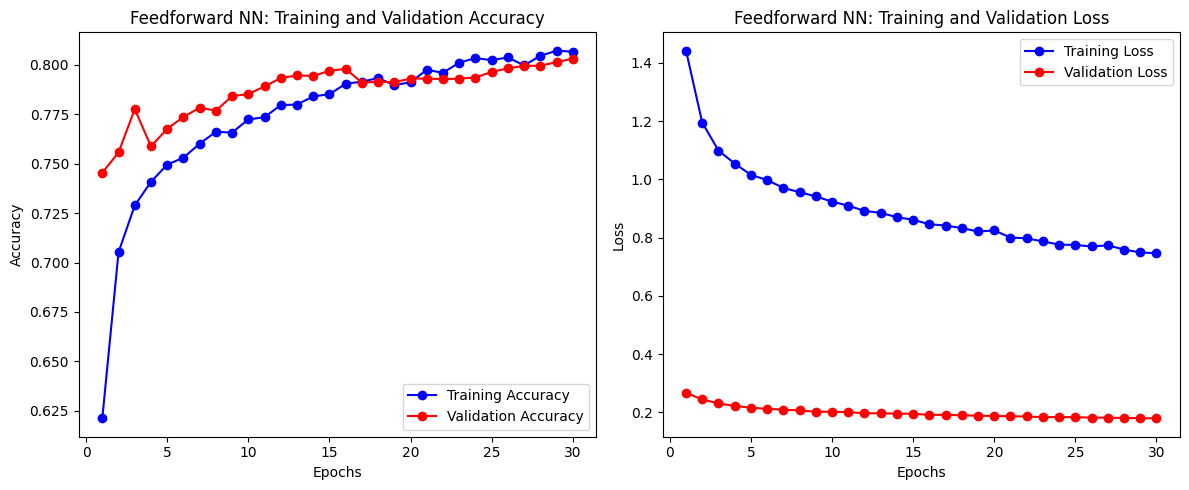

In [ ]:
# Plot the history
plot_history(history_ff, model_name="Feedforward NN")

The training process stops after 30 epochs, hence the early stopping has not been activated. Both training and validation accuracy steadily increase and both the losses constantly decrease. It is a good and normal behavior with nothing strange and with a final validation accuracy higher than 94%, so it seems to be a decent result.

Now we test the model on the test set and we inspect the **classification report**.

In [ ]:
# Predictions on test set (probabilities)
y_pred_probs = ff_model.predict(X_test)

# From one-hot to index
y_test_idx = np.argmax(np.array(y_test), axis=-1)
y_pred_idx = np.argmax(y_pred_probs, axis=-1)

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 253ms/step


In [ ]:
# Convert index to tag
y_test_tags = [[idx2tag[idx] for idx in seq] for seq in y_test_idx]
y_pred_tags = [[idx2tag[idx] for idx in seq] for seq in y_pred_idx]

# Flatten and remove padding
true_tags = []
pred_tags = []

for true_seq, pred_seq in zip(y_test_tags, y_pred_tags):
    for t, p in zip(true_seq, pred_seq):
      if t != 'PAD':
          true_tags.append(t)
          pred_tags.append(p)

In [ ]:
# Classification report
print(classification_report(true_tags, pred_tags))

              precision    recall  f1-score   support

       I-LOC       0.31      0.54      0.39       121
      I-MISC       0.29      0.50      0.37       135
       I-ORG       0.27      0.49      0.35       198
       I-PER       0.38      0.65      0.48       132
           O       0.99      0.85      0.91      2911

    accuracy                           0.79      3497
   macro avg       0.45      0.61      0.50      3497
weighted avg       0.88      0.79      0.83      3497



Despite the weights, the neural network still perform well on the dominant class ('o') and struggle on the others. However, considering that a feed forward neural network as this one is not an optimal choice for sequences like texts, the results we obtained are in line with expectations.

# 6. LSTM

In this section, we explore the application of **Long Short-Term Memory (LSTM)** networks for the Named Entity Recognition (NER) task. Unlike feed-forward neural networks, LSTMs are a type of recurrent neural network (RNN) designed to capture temporal dependencies in sequential data. Their architecture addresses the vanishing gradient problem by introducing memory cells and gating mechanisms, allowing them to retain information over longer sequences. This makes LSTMs particularly well-suited for tasks like NER, where understanding the context and order of words is essential for accurate classification.

We implement a model with the following layers:
- An embedding layer that uses the pretrained GloVe;
- Two bidirectional LSTM layers with 256 ans 128 units respectively;
- The final dense layer with Softmax activation function for classification.

In [ ]:
# Set the seed
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [ ]:
# Create the model
lstm_model = Sequential()

# Embedding layer with pretrained GloVe
lstm_model.add(Embedding(input_dim = len(word2idx),
                         output_dim = embedding_matrix.shape[1],
                         weights = [embedding_matrix],
                         mask_zero=True,
                         trainable=True))

# LSTM layers
lstm_model.add(Bidirectional(LSTM(units=256, return_sequences=True, dropout=0.5)))
lstm_model.add(Bidirectional(LSTM(units=128, return_sequences=True, dropout=0.5)))

# Dense layer to output tag probabilities
lstm_model.add(Dense(len(tag2idx), activation='softmax'))

# Compile
lstm_model.compile(optimizer=Adam(learning_rate=0.001),
                   loss='categorical_crossentropy',
                   metrics=[masked_accuracy])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
# Train the model
history_lstm = lstm_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    sample_weight=sample_weights,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - loss: 4.6234 - masked_accuracy: 0.3848 - val_loss: 1.1124 - val_masked_accuracy: 0.6301
Epoch 2/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 3.8028 - masked_accuracy: 0.6262 - val_loss: 0.8998 - val_masked_accuracy: 0.6851
Epoch 3/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 3.2548 - masked_accuracy: 0.7161 - val_loss: 0.7646 - val_masked_accuracy: 0.7244
Epoch 4/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 2.8375 - masked_accuracy: 0.7478 - val_loss: 0.7926 - val_masked_accuracy: 0.7346
Epoch 5/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 2.5523 - masked_accuracy: 0.7743 - val_loss: 0.7342 - val_masked_accuracy: 0.7452
Epoch 6/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 2.2487 - masked_accuracy: 0.7898 - val_loss: 0.6378 - val_masked_accuracy: 0.7820
Epoch 7/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 2.0393 - masked_accuracy: 0.8137 - val_loss: 0.7378 - val_masked_accuracy: 0.7530
Epoch 8/30
4

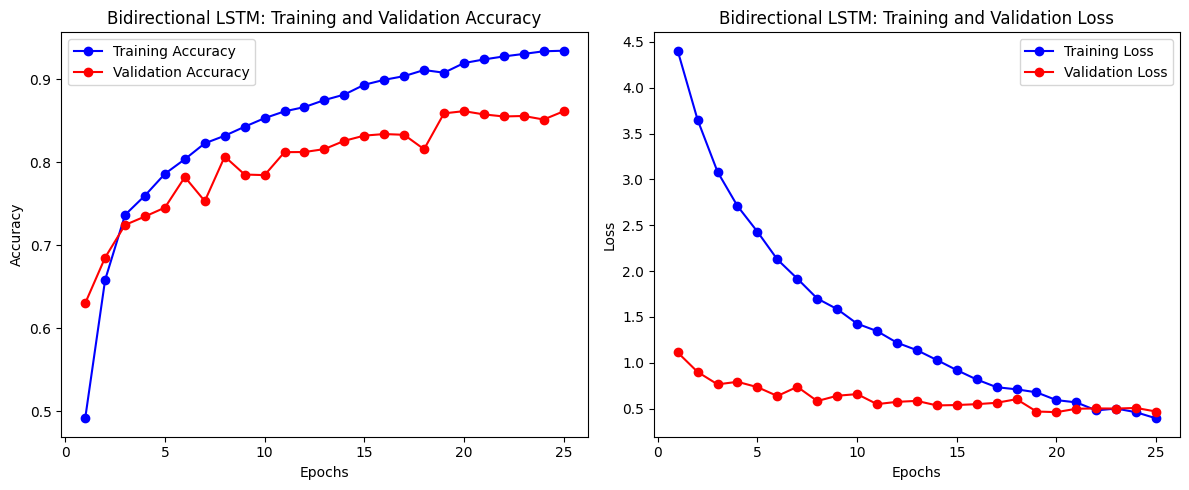

In [ ]:
# Plot the history
plot_history(history_lstm, model_name="Bidirectional LSTM")

In [ ]:
# Predictions on test set (probabilities)
y_pred_probs_lstm = lstm_model.predict(X_test)

# From one-hot to index
y_pred_idx_lstm = np.argmax(y_pred_probs_lstm, axis=-1)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step


In [ ]:
# Convert index to tag
y_pred_tags_lstm = [[idx2tag[idx] for idx in seq] for seq in y_pred_idx_lstm]

# Flatten and remove padding
true_tags = []
pred_tags_lstm = []

for true_seq, pred_seq in zip(y_test_tags, y_pred_tags_lstm):
    for t, p in zip(true_seq, pred_seq):
      if t != 'PAD':
          true_tags.append(t)
          pred_tags_lstm.append(p)

In [ ]:
# Classification report
print(classification_report(true_tags, pred_tags_lstm))

              precision    recall  f1-score   support

       I-LOC       0.48      0.65      0.55       121
      I-MISC       0.30      0.61      0.41       135
       I-ORG       0.45      0.54      0.49       198
       I-PER       0.51      0.81      0.63       132
           O       0.99      0.89      0.94      2911

    accuracy                           0.85      3497
   macro avg       0.55      0.70      0.60      3497
weighted avg       0.90      0.85      0.87      3497



The perormance of the LSTM model is slightly better than the Feed Forward model, but not good enough, it still struggles to recognize Named Entities.

# 7. BERT

After evaluating traditional neural architectures such as feedforward networks and LSTMs for the Named Entity Recognition (NER) task, we now shift our attention to a state-of-the-art transformer-based approach: **BERT** (Bidirectional Encoder Representations from Transformers). Unlike previous models that learn representations sequentially, BERT leverages the full context of a word by looking both left and right in a sentence simultaneously through its attention mechanism. This bidirectional nature makes it especially powerful for NER, where understanding a word’s role depends heavily on its surrounding context. In this section, we fine-tune a pre-trained BERT model on our NER dataset and evaluate its performance compared to the previously implemented architectures.

For BERT, we also need to change some of the preprocessing steps we did, because it has specific requirements that differ from traditional models like LSTM or feedforward networks. First of all, we will fine-tune a pretrained BERT, so wee need to use the same tokenizer that was used during BERT's pretraining.

In [ ]:
# Add a column for the sentence number
sentence_id = 1
sentence_ids = []

# Generate 'Sentence_num' based on sentence delimiters
for token in data['Token']:
    sentence_ids.append(sentence_id)
    if token in {'.', '!', '?'}:  # Consider these characters as sentence delimiters
        sentence_id += 1

# Assign the 'Sentence_num' column to the DataFrame
data['Sentence_num'] = sentence_ids
data

,Token,Tag,Sentence_num
0,010,I-MISC,1
1,is,O,1
2,the,O,1
3,tenth,O,1
4,album,O,1
...,...,...,...
39147,a,O,1660
39148,Russian,I-MISC,1660
39149,singer,O,1660
39150,.,O,1660


In [ ]:
# Re-define label_dict without the 'PAD' tag
label_dict = {
    "O": 0,         # Token outside any entity
    "I-MISC": 1,    # Token for Miscellaneous entities
    "I-PER": 2,     # Token for PERSON entities
    "I-ORG": 3,     # Token for ORGANIZATION entities
    "I-LOC": 4      # Token for LOCATION entities
}

In [ ]:
# Remove punctuation and docstart
wiki = data[~data['Token'].isin(list(string.punctuation))].reset_index(drop=True)
wiki = wiki[wiki['Token'] != '-DOCSTART-'].reset_index(drop=True)

In [ ]:
wiki['sentence'] = wiki[['Sentence_num','Token','Tag']].groupby(['Sentence_num'])['Token'].transform(lambda x: ' '.join(x))
wiki['word_labels'] = wiki[['Sentence_num','Token','Tag']].groupby(['Sentence_num'])['Tag'].transform(lambda x: ','.join(x))
wiki = wiki[["sentence", "word_labels"]].drop_duplicates().reset_index(drop=True)
wiki

,sentence,word_labels
0,010 is the tenth album from Japanese Punk Tech...,"I-MISC,O,O,O,O,O,I-MISC,O,O,O,I-ORG,I-ORG,I-OR..."
1,This album proved to be more commercial and mo...,"O,O,O,O,O,O,O,O,O,O,O,I-MISC,O,O,O,O,O,I-MISC,..."
2,Founding member Kojima Minoru played guitar on...,"O,O,I-PER,I-PER,O,O,O,I-MISC,I-MISC,O,I-MISC,O..."
3,XXX can of This had a different meaning and mo...,"I-MISC,I-MISC,I-MISC,I-MISC,O,O,O,O,O,O,O,O,O,..."
4,it was later explained that the song was about...,"O,O,O,O,O,O,O,O,O,I-MISC,O,O,O,O,O,I-MISC,O,O,..."
...,...,...
1649,This major has been gaining recognition for FS...,"O,O,O,O,O,O,O,I-ORG,O,O,O,O,O,O,O,O"
1650,The Robert C. Byrd National Aerospace Educatio...,"O,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,O,..."
1651,Fairmont State 's athletic teams known as the ...,"I-ORG,I-ORG,O,O,O,O,O,O,I-ORG,O,O,O,I-ORG,I-OR..."
1652,A list of works by Justin Broadrick,"O,O,O,O,O,I-PER,I-PER"


In [ ]:
# Use the "fast" version of the Bert tokenizer
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

The function `encode_sentences` below is designed to prepare our token-level NER data for use with BERT. It takes as input a list of the tokenized sentences, the corresponding NER tags, a mapping of tags to indices and the maximum sequence length. The function performs the following operations:

1. **Tokenization with alignment**: for each word in each sentence, the function uses the Bert Tokenizer Fast to tokenize it into subwords. Furthermore, it keeps track of which subword is the first for each original word and it aligns labels only with the first subword to maintain label integrity.

2. **Padding and truncation**: the tokenized input is padded or truncated to the maximum lenght of 70. Labels are padded as well with a special index, -100, so they can be ignored in the loss computation.

3. **Attention masks**: A binary mask is generated to indicate which tokens are real (1) and which are padding (0).

4. **Output formatting**: It returns the token IDs, the masks, and the tags converted to numerical format and aligned with tokens, all as torch.Tensor-compatible structures to be passed into a DataLoader.

In [ ]:
def prepare_bert_inputs(dataset, tokenizer, label_dict, max_length=70):
    input_ids = []
    attention_masks = []
    label_list = []

    for _, row in dataset.iterrows():
        try:
            sentence = row["sentence"].split()
            tags = row["word_labels"].split(",")
            encoded = tokenizer(
                sentence,
                is_split_into_words=True, # the input is already a sequence of word
                padding="max_length",
                truncation=True,
                max_length=max_length,
                return_tensors="pt" # pythorch tensors
            )

            # Generate labels for subtokens
            labels = []
            word_ids = encoded.word_ids()
            for word_idx in word_ids:
                if word_idx is None:
                    labels.append(-100)
                else:
                    # Map only the first subtokens
                    if word_idx >= len(tags):
                        print(f"Mapping error: word_idx={word_idx}, tags={tags}")
                        labels.append(-100)
                    else:
                        labels.append(label_dict.get(tags[word_idx], -100))

            # Check final alignment
            if len(encoded["input_ids"].squeeze().tolist()) != len(labels): # just remove additional dimensions and return a list
                print(f"Misalignment: Tokens={len(encoded['input_ids'].squeeze().tolist())}, Labels={len(labels)}")

            input_ids.append(encoded["input_ids"].squeeze().tolist())
            attention_masks.append(encoded["attention_mask"].squeeze().tolist())
            label_list.append(labels)
        except Exception as e:
            print(f"Error with row {row}: {e}")

    return input_ids, attention_masks, label_list

This NERDataset class is a [PyTorch dataset](https://pytorch.org/docs/stable/data.html) It ensures that the tokenized inputs (input_ids), attention masks, and labels are of the same length and provides an interface for accessing the data in a structured format. The class includes methods to:

1. Return the total number of samples (__len__).

2. Retrieve individual samples as PyTorch tensors in the form of a dictionary containing input_ids, attention_mask, and labels (__getitem__).

The dataset is compatible with PyTorch’s DataLoader, making it convenient for batching and shuffling during the training and evaluation phases.

In [ ]:
class NERDataset(Dataset): # building a custom estension of Dataset of torch.utils
    def __init__(self, input_ids, attention_masks, labels):
        assert len(input_ids) == len(attention_masks) == len(labels), \
            "Lengths of input_ids, attention_masks, and labels do not match"
        self.input_ids = input_ids # setting the class with our data
        self.attention_masks = attention_masks
        self.labels = labels

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        if idx >= len(self.input_ids) or idx < 0:
            raise IndexError(f"Index {idx} is out of bounds")
        return {
            "input_ids": torch.tensor(self.input_ids[idx], dtype=torch.long),
            "attention_mask": torch.tensor(self.attention_masks[idx], dtype=torch.long),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long),
        }

We split the dataset into train and test, and create the two NERDatasets.

In [ ]:
# Training percentage
train_size = 0.8

# Split the original dataset
train_dataset = wiki.sample(frac=train_size, random_state=42)
test_dataset = wiki.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)

print("FULL Dataset: {}".format(wiki.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

# Prepare the data for BERT
train_input_ids, train_attention_masks, train_labels = prepare_bert_inputs(
    train_dataset, tokenizer, label_dict, max_length=70
)
test_input_ids, test_attention_masks, test_labels = prepare_bert_inputs(
    test_dataset, tokenizer, label_dict, max_length=70
)

# Creating Pythorch tensors
training_set = NERDataset(train_input_ids, train_attention_masks, train_labels)
testing_set = NERDataset(test_input_ids, test_attention_masks, test_labels)

# Check the dimensions
print("Training set size:", len(training_set))
print("Testing set size:", len(testing_set))


FULL Dataset: (1654, 2)
TRAIN Dataset: (1323, 2)
TEST Dataset: (331, 2)
Training set size: 1323
Testing set size: 331


Now we fine-tune the pre-trained BERT on our dataset and save the fine-tuned model on Drive so that we can load it on later runs without training again.

- **Model Setup:**
  - A pre-trained BERT model (`bert-base-uncased`) is fine-tuned for token classification,
  - The model is placed on GPU (`cuda`) if available, otherwise on CPU.

- **Training Configuration:**
  - A smaller batch size (`8`) is used to handle long sequences, with a learning rate of `5e-5`.
  - Training is limited to 5 epochs to prevent overfitting, and weight decay (`0.01`) is applied for regularization.

- **Metrics Calculation:**
  - Accuracy and weighted F1-score are computed after masking padding tokens (`-100`) to ensure valid evaluations.

- **Trainer Initialization:**
  - The `Trainer` class handles training, evaluation, and logging, using the specified datasets and metric function.

- **Training Execution:**
  - The `trainer.train()` method runs the fine-tuning process, optimizing the BERT model for the NER task.


In [ ]:
# Create the model and put it on the gpu
device = "cuda" if torch.cuda.is_available() else "cpu"
num_labels = len(label_dict)
model = BertForTokenClassification.from_pretrained("bert-base-uncased", num_labels=num_labels)
model = model.to(device)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Set the seed
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [ ]:
# Configuration for training
batch_size = 8
logging_steps = max(1, len(training_set) // batch_size)
model_name = "BERT-finetuned"

# Training arguments
training_args = TrainingArguments(
    output_dir=model_name,
    num_train_epochs=5,
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    weight_decay=0.01,
    logging_steps=logging_steps,
    save_strategy="epoch",  # Save checkpoint at every epoch
    load_best_model_at_end=False, # Keep the model at last epoch
    report_to="none",
)

In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    # Ignore special tokens (-100), which are related to padding
    mask = labels != -100
    labels = labels[mask]
    preds = preds[mask]

    # Calculate metrics
    accuracy = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="weighted")

    return {"accuracy": accuracy, "f1": f1}

In [ ]:
# Trainer configuration
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=training_set,
    eval_dataset=testing_set,
    compute_metrics=compute_metrics,
)

# Execute training
trainer.train()

Step,Training Loss
165,0.300400
330,0.089200
495,0.038700
660,0.018500
825,0.007400


TrainOutput(global_step=830, training_loss=0.09033797800271626, metrics={'train_runtime': 221.238, 'train_samples_per_second': 29.9, 'train_steps_per_second': 3.752, 'total_flos': 236321767363500.0, 'train_loss': 0.09033797800271626, 'epoch': 5.0})

In [ ]:
# Load the fine-tuned model
bert_model = BertForTokenClassification.from_pretrained("/content/drive/MyDrive/Università/Text Mining/BERT-finetuned/checkpoint-830")

We use the fine-tuned model to make predicitons on the test set and compute metrics.

In [ ]:
# Set model to evaluation mode
bert_model.eval()
bert_model.to(device)

# Create a dataloader
test_loader = DataLoader(testing_set, batch_size=32)

# Predictions on test data
true_labels = []
pred_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)

        mask = labels != -100  # ignore padding

        for i in range(labels.size(0)):
            true_seq = labels[i][mask[i]].cpu().numpy()
            pred_seq = predictions[i][mask[i]].cpu().numpy()

            true_labels.extend(true_seq)
            pred_labels.extend(pred_seq)

In [ ]:
# Map ids to tags
idx2tag = {i: tag for tag, i in label_dict.items()}
true_tags = [idx2tag[i] for i in true_labels]
pred_tags = [idx2tag[i] for i in pred_labels]

In [ ]:
# Metrics
print(classification_report(true_tags, pred_tags, digits=4))

              precision    recall  f1-score   support

       I-LOC     0.8289    0.8807    0.8540       352
      I-MISC     0.7671    0.8037    0.7850       377
       I-ORG     0.8936    0.8400    0.8660       550
       I-PER     0.9615    0.9345    0.9478       534
           O     0.9821    0.9834    0.9827      5908

    accuracy                         0.9564      7721
   macro avg     0.8866    0.8885    0.8871      7721
weighted avg     0.9569    0.9564    0.9565      7721



The confusion matrix shows excellent predictions for the majority class ("O") and slightly worse performance for the other tags, but a **solid result overall**. Among the Named Entity tags, "I-PER" has significantly better results compared to the other classes. Precision and recall macro averages are perfectly balanced, indicating the model is effective in capturing both the majority and minority classes.

# 8. Conclusion

In this project, we developed and evaluated three distinct deep learning models for the task of Named Entity Recognition: a Feedforward Neural Network (FFNN), a Long Short-Term Memory network (LSTM), and a pre-trained BERT model fine-tuned on our dataset. Here are some condirations:

- The **FFNN** served as a solid baseline, but its inability to account for word order limited its performance, especially on ambiguous tokens.

- The **LSTM** significantly improved results by capturing sequential dependencies and context, but performance wa still pretty poor.

- The **BERT** model outperformed both previous approaches across all metrics. Its deep, transformer-based architecture and pre-trained contextual embeddings allowed it to excel.



In [ ]:
# Data for the table
data = {
    "Model": ["FFNN", "LSTM", "BERT"],
    "Accuracy": [0.79, 0.85, 0.96],
    "Precision": [0.45, 0.55, 0.89],
    "Recall": [0.61, 0.70, 0.89],
    "F1-score": [0.50, 0.60, 0.89]
}

# Create DataFrame
df = pd.DataFrame(data)

# Display it nicely
df.style.set_caption("Model Performance Comparison (NER Task)").format({
    "Accuracy": "{:.0%}",
    "Precision": "{:.0%}",
    "Recall": "{:.0%}",
    "F1-score": "{:.0%}"
})

,Model,Accuracy,Precision,Recall,F1-score
0,FFNN,79%,45%,61%,50%
1,LSTM,85%,55%,70%,60%
2,BERT,96%,89%,89%,89%


We present below a box where the user can input a sentence and get the predicted labels for each word generated by the fine-tuned BERT.

In [ ]:
def predict_tags(sentence):
    # Tokenize input sentence
    encoding = tokenizer(sentence, return_tensors="pt", truncation=True, is_split_into_words=False)
    input_ids = encoding["input_ids"].to(device)
    attention_mask = encoding["attention_mask"].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=-1).squeeze().cpu().numpy()

    tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze())
    tags = [idx2tag[pred] for pred in predictions]

    print("\nNER Predictions:")
    for token, tag in zip(tokens, tags):
        print(f"{token:15} --> {tag}")

In [ ]:
# Set model to evaluation mode
bert_model.eval()
bert_model.to(device)

# Create input widget
text_input = widgets.Text(
    value='',
    placeholder='Enter a sentence...',
    description='Input:',
    layout=widgets.Layout(width='100%')
)

button = widgets.Button(description="Predict Tags")

# Define callback
def on_button_clicked(b):
    sentence = text_input.value
    predict_tags(sentence)

button.on_click(on_button_clicked)

# Display widgets
display(text_input, button)

Text(value='', description='Input:', layout=Layout(width='100%'), placeholder='Enter a sentence...')

Button(description='Predict Tags', style=ButtonStyle())


NER Predictions:
[CLS]           --> O
hello           --> O
,               --> O
my              --> O
name            --> O
is              --> O
alex            --> I-PER
and             --> O
i               --> O
live            --> O
in              --> O
italy           --> I-LOC
.               --> O
i               --> O
studied         --> O
at              --> O
un              --> I-ORG
##iver          --> I-ORG
##sit           --> I-ORG
##a             --> I-ORG
cat             --> I-ORG
##to            --> I-ORG
##lica          --> I-ORG
and             --> O
i               --> O
am              --> O
currently       --> O
working         --> O
at              --> O
nt              --> I-ORG
##t             --> I-ORG
data            --> I-ORG
.               --> O
[SEP]           --> O


The results demonstrate a clear trend: as the models gain the ability to understand context (FFNN → LSTM → BERT), their performance on the NER task improves substantially. BERT's superior results validate the effectiveness of transfer learning and contextualized embeddings in modern NLP. While BERT demands more computational resources, the trade-off is justified by its high accuracy and robustness.